In [3]:
import h5py
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

"""
於'Data-driven prediction of battery cycle life before capacity degradation'中使用的dataset
由124顆商用LFP電池(APR18650M1A)組成 以快充及4C放電循環至EoL
其額定電容量為1.11Ah 額定電壓為3.3V
資料被分為三個bath
"""
def mat_to_pkl():
    """
    將mat檔中需要的資料截取至pkl檔
    """
    filename = ['2017-05-12_batchdata_updated_struct_errorcorrect.mat',
                '2017-06-30_batchdata_updated_struct_errorcorrect.mat',
                '2018-04-12_batchdata_updated_struct_errorcorrect.mat']
    # 各batch有問題的電池 須排除
    b1_err = [0, 1, 2, 3, 4, 8, 10, 12, 13, 18, 22]
    b2_err = [1, 6, 9, 10, 21, 25]
    b3_err = [23, 32, 37]
    bat_dict = {}  # dict. for all batch imformation
    for b in range(len(filename)): # batch數
        f = h5py.File(filename[b], 'r')
        batch = f['batch']
        num_cells = batch['summary'].shape[0]
        for i in range(num_cells): # 該batch下的電池cell數量
            """
            以下資料暫時不使用
            policy = f[batch['policy_readable'][i, 0]][()].tobytes()[::2].decode()
            summary_IR = np.hstack(f[batch['summary'][i, 0]]['IR'][0, :].tolist())
            summary_CY = np.hstack(f[batch['summary'][i, 0]]['cycle'][0, :].tolist())
            """
            if b==0 and i in b1_err:
                continue
            if b==1 and i in b2_err:
                continue
            if b==2 and i in b3_err:
                continue
            cl = f[batch['cycle_life'][i, 0]][()]
            summary_QC = np.hstack(f[batch['summary'][i, 0]]['QCharge'][0, :].tolist())
            summary_QD = np.hstack(f[batch['summary'][i, 0]]['QDischarge'][0, :].tolist())
            summary_CT = np.hstack(f[batch['summary'][i, 0]]['chargetime'][0, :].tolist())
            summary_TA = np.hstack(f[batch['summary'][i, 0]]['Tavg'][0, :].tolist())
            summary_TM = np.hstack(f[batch['summary'][i, 0]]['Tmin'][0, :].tolist())
            summary_TX = np.hstack(f[batch['summary'][i, 0]]['Tmax'][0, :].tolist())
            summary = {'QC': summary_QC, 'QD': summary_QD, 'chargetime': summary_CT, 
                        'TMIN': summary_TM, 'TMAX': summary_TX, 'TAVG': summary_TA}
            cycles = f[batch['cycles'][i, 0]]
            cycle_dict = {}
            for j in range(1, cycles['I'].shape[0]): # 該cell實驗運行的cycle數
                """
                以下資料暫時不使用
                Qdlin = np.hstack((f[cycles['Qdlin'][j, 0]][()]))
                Tdlin = np.hstack((f[cycles['Tdlin'][j, 0]][()]))
                dQdV = np.hstack((f[cycles['discharge_dQdV'][j, 0]][()]))
                t = np.hstack((f[cycles['t'][j, 0]][()]))
                """
                T = np.hstack((f[cycles['T'][j, 0]]))
                I = np.hstack((f[cycles['I'][j, 0]]))
                V = np.hstack((f[cycles['V'][j, 0]]))
                Qc = np.hstack((f[cycles['Qc'][j, 0]]))
                Qd = np.hstack((f[cycles['Qd'][j, 0]]))
                dd = np.diff(np.diff(Qd))
                dis_s = np.where(np.diff(Qd)>=1e-3)[0][0] # 放電開始
                dis_e = np.where(dd>1e-4)[0][-1]+1 # 放電結束
                cd = {'I': I[dis_s:dis_e], 'Qd': Qd[dis_s:dis_e], 'V': V[dis_s:dis_e], 'T': T[dis_s:dis_e]}
                cycle_dict[str(j)] = cd

            cell_dict = {'cycle_life': cl, 'summary': summary, 'cycles': cycle_dict}
            if b == 0:
                key = 'b1c' + str(i).zfill(2)
            elif b == 1:
                key = 'b2c' + str(i).zfill(2)
            else:
                key = 'b3c' + str(i).zfill(2)
            print(key)
            bat_dict[key] = cell_dict

    print(len(bat_dict.keys()), bat_dict.keys())
    with open('all_batch_dc.pkl', 'wb') as fp:
        pickle.dump(bat_dict, fp)

dict_keys(['b1c05', 'b1c06', 'b1c07', 'b1c09', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c00', 'b2c02', 'b2c03', 'b2c04', 'b2c05', 'b2c07', 'b2c08', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c15', 'b2c16', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c22', 'b2c23', 'b2c24', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47', 'b3c00', 'b3c01', 'b3c02', 'b3c03', 'b3c04', 'b3c05', 'b3c06', 'b3c07', 'b3c08', 'b3c09', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b3c19', 'b3c20', 'b3c21', 'b3c22', 'b3c24', 'b3c25', 'b3c26', 'b3c27', 'b3c28', 'b3c29', 'b3c30', 'b3c31', 'b3c33', 'b3c34',

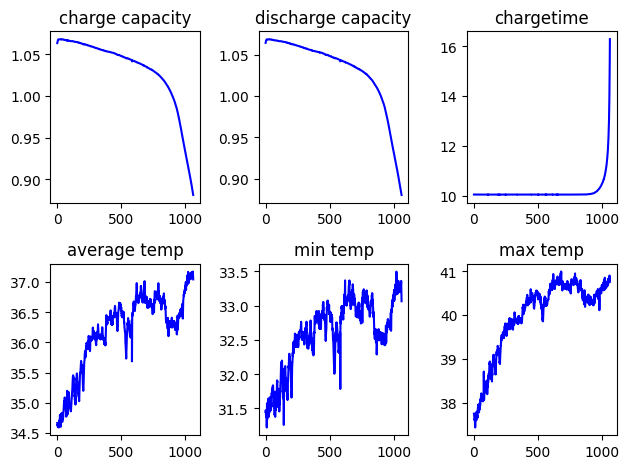

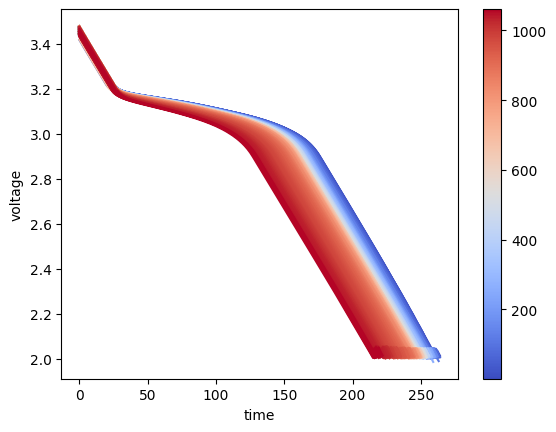

In [9]:
# mat_to_pkl()
severson = pickle.load(open('all_batch_dc.pkl', 'rb'))
print(severson.keys())  # 電芯編號
# 視覺化
fig, ax = plt.subplots(2, 3) # 循環間資訊
ax[0, 0].plot(severson['b3c01']['summary']['QC'], c='blue')
ax[0, 0].set_title('charge capacity')
ax[0, 1].plot(severson['b3c01']['summary']['QD'], c='blue')
ax[0, 1].set_title('discharge capacity')
ax[0, 2].plot(severson['b3c01']['summary']['chargetime'], c='blue')
ax[0, 2].set_title('chargetime')
ax[1, 0].plot(severson['b3c01']['summary']['TAVG'], c='blue')
ax[1, 0].set_title('average temp')
ax[1, 1].plot(severson['b3c01']['summary']['TMIN'], c='blue')
ax[1, 1].set_title('min temp')
ax[1, 2].plot(severson['b3c01']['summary']['TMAX'], c='blue')
ax[1, 2].set_title('max temp')
plt.tight_layout()
plt.show()
plt.close()
n_cycles = len(severson['b3c01']['cycles'].keys())
cmap = plt.get_cmap('coolwarm')
for i in range(n_cycles):  # 循環內資訊
    plt.plot(severson['b3c01']['cycles'][str(i+1)]['V'], c=cmap(i/n_cycles))
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=1, vmax=n_cycles),cmap='coolwarm')
sm.set_array([])
plt.colorbar(sm)
plt.ylabel('voltage')
plt.xlabel('time')
plt.show()

In [ ]:
# 切出1~100cycle的V-Q曲線
def pkl_preprocessing(filename='all_batch_dc.pkl', index=[0, 100]):
    path = 'Severson_Dataset/'
    dataset = pickle.load(open(filename, 'rb'))
    chargetime = []
    for cell_id in tqdm(dataset.keys()):
        curve, RUL = [], []
        cl = dataset[cell_id]['cycle_life']
        n_cycles = len(dataset[cell_id]['cycles'].keys())
        for i in range(n_cycles):
            cycle_id = i+1
            if cl-cycle_id>=1 and cycle_id>1:
                V = dataset[cell_id]['cycles'][str(i)]['V']
                Qd = dataset[cell_id]['cycles'][str(i)]['Qd']
                I = dataset[cell_id]['cycles'][str(i)]['I']
                T = dataset[cell_id]['cycles'][str(i)]['T']
                if len(V) < 1:  # wrong data points number
                    print(cell_id)
                    continue
                # 把資料一律線性插值到500個POINT
                interp_id = np.linspace(0, len(V)-1, 500)
                V_interp = np.interp(interp_id, np.arange(len(V)), V).reshape(1, -1)
                Qd_interp = np.interp(interp_id, np.arange(len(Qd)), Qd).reshape(1, -1)
                I_interp = np.interp(interp_id, np.arange(len(I)), I).reshape(1, -1)
                T_interp = np.interp(interp_id, np.arange(len(T)), T).reshape(1, -1)
                VQIT = np.concatenate([V_interp, Qd_interp, I_interp, T_interp], axis=0)
                curve.append(np.expand_dims(VQIT, axis=0))
                RUL.append(cl-cycle_id)
        curve = np.concatenate(curve, axis=0)
        RUL = np.array(RUL)
        np.save(path+cell_id+"_Curve", curve[index[0]:index[1]])    
        np.save(path+cell_id+"_RUL", RUL[index[0]:index[1]])   